In [1]:
import requests
import base64
import io
from pathlib import Path
from PIL import Image
from IPython.display import display, HTML

In [2]:
def encode_image_to_base64(image_path: Path) -> str:
    """
    encode the image file path to a base64 string
    if the file exists, read the original bytes
    if the file does not exist, create a dummy black image
    """
    if image_path.exists():
        # if the file exists, read the original bytes
        print(f"Encoding real image from: {image_path}")
        with image_path.open("rb") as image_file:
            image_bytes = image_file.read()
    else:
        # if the file does not exist, create a dummy black image
        print(f"Warning: '{image_path}' not found. Creating a dummy black image.")
        img = Image.new("RGB", (224, 224), color="black")

        # convert the dummy image to in-memory bytes
        with io.BytesIO() as buf:
            img.save(buf, format="JPEG")
            image_bytes = buf.getvalue()

    # encode the image bytes to base64 string
    return base64.b64encode(image_bytes).decode("utf-8")


In [7]:
api_url = "http://0.0.0.0:8000/predict"
base_folder = Path("../frames")

img_paths = list(base_folder.glob("*.jpg"))

print(f"Encoding {len(img_paths)} images for batch request...")
try:
    base64_images = [encode_image_to_base64(img_path) for img_path in img_paths]
except Exception as e:
    print(f"Error encoding images: {e}")
    raise e

# The JSON payload must match the Pydantic model in api.py
payload = {"images": base64_images}

# send the request to the API
print(f"Sending batch request to {api_url}...")
try:
    response = requests.post(api_url, json=payload)
    response.raise_for_status()
    print("Request successful!")
    
    # prediction to json
    predictions_json = response.json()['predictions']
    print("Prediction successful!")

except requests.exceptions.ConnectionError:
    print("\n--- ERROR ---")
    print("Could not connect to the API server.")

except Exception as e:
    print(f"An error occurred: {e}")


Encoding 9 images for batch request...
Encoding real image from: ../frames/frame_6.jpg
Encoding real image from: ../frames/frame_7.jpg
Encoding real image from: ../frames/frame_5.jpg
Encoding real image from: ../frames/frame_4.jpg
Encoding real image from: ../frames/frame_0.jpg
Encoding real image from: ../frames/frame_1.jpg
Encoding real image from: ../frames/frame_3.jpg
Encoding real image from: ../frames/frame_2.jpg
Encoding real image from: ../frames/frame_8.jpg
Sending batch request to http://0.0.0.0:8000/predict...
Request successful!
Prediction successful!



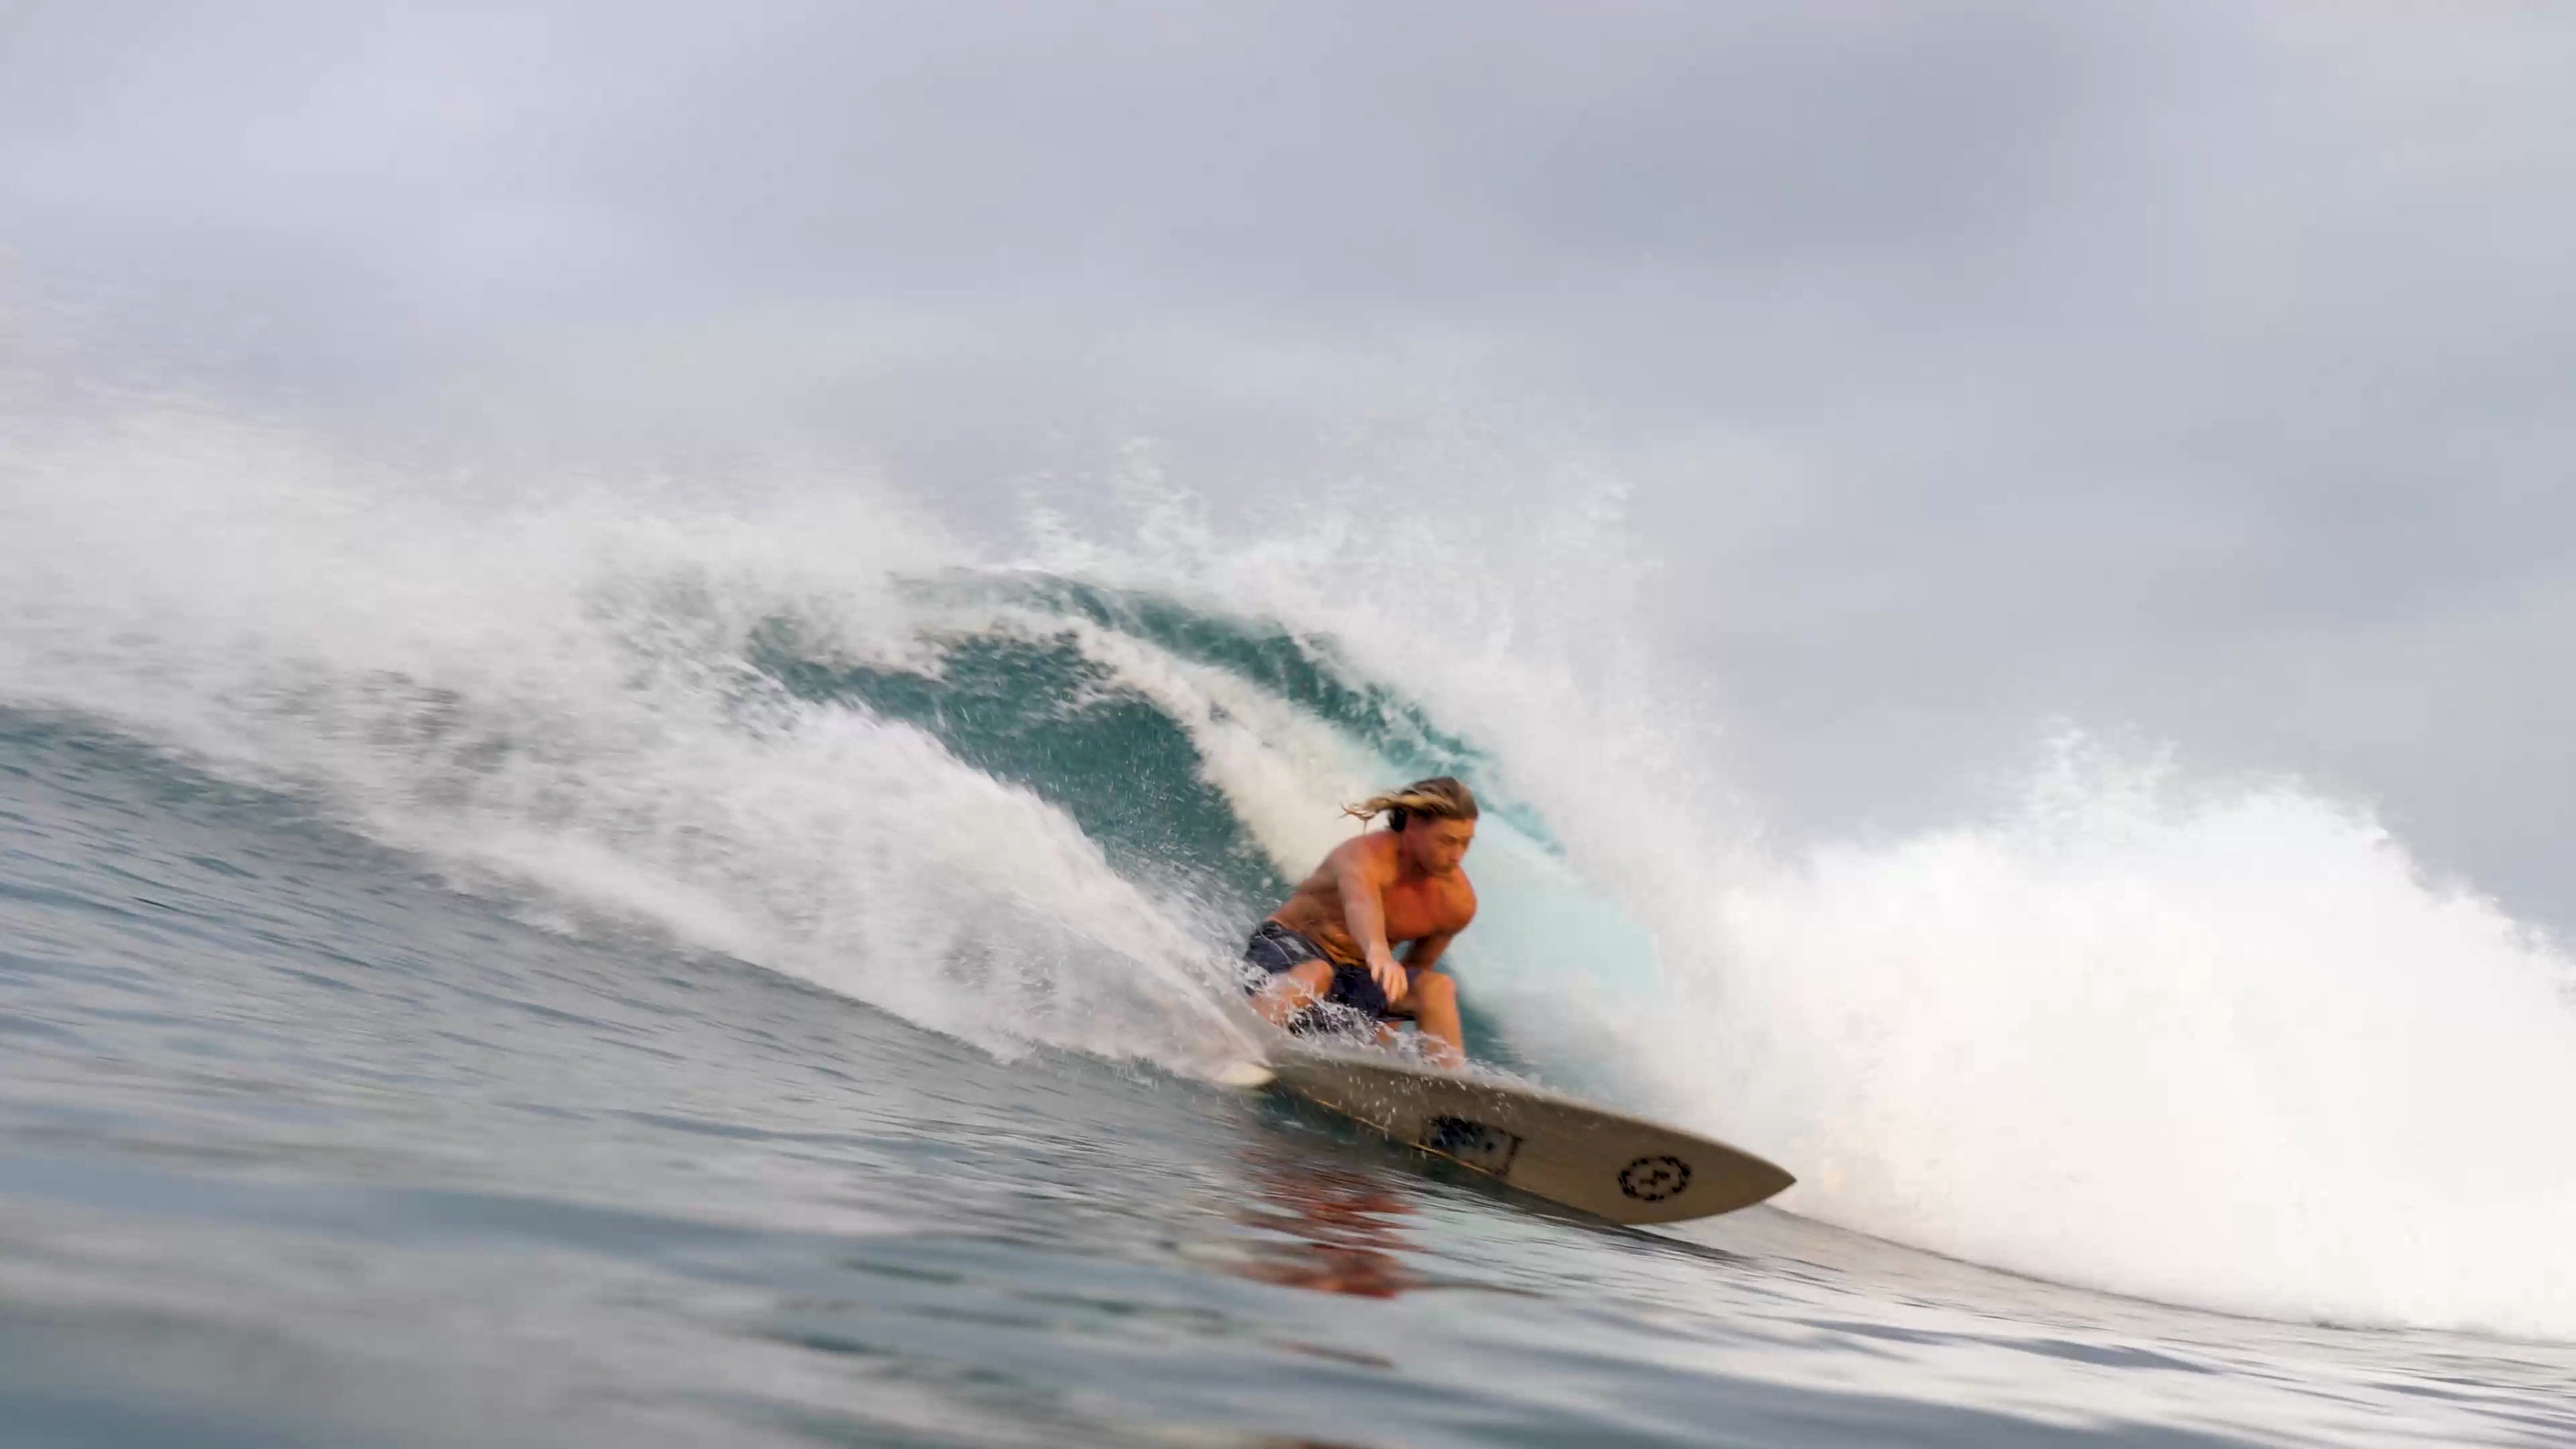
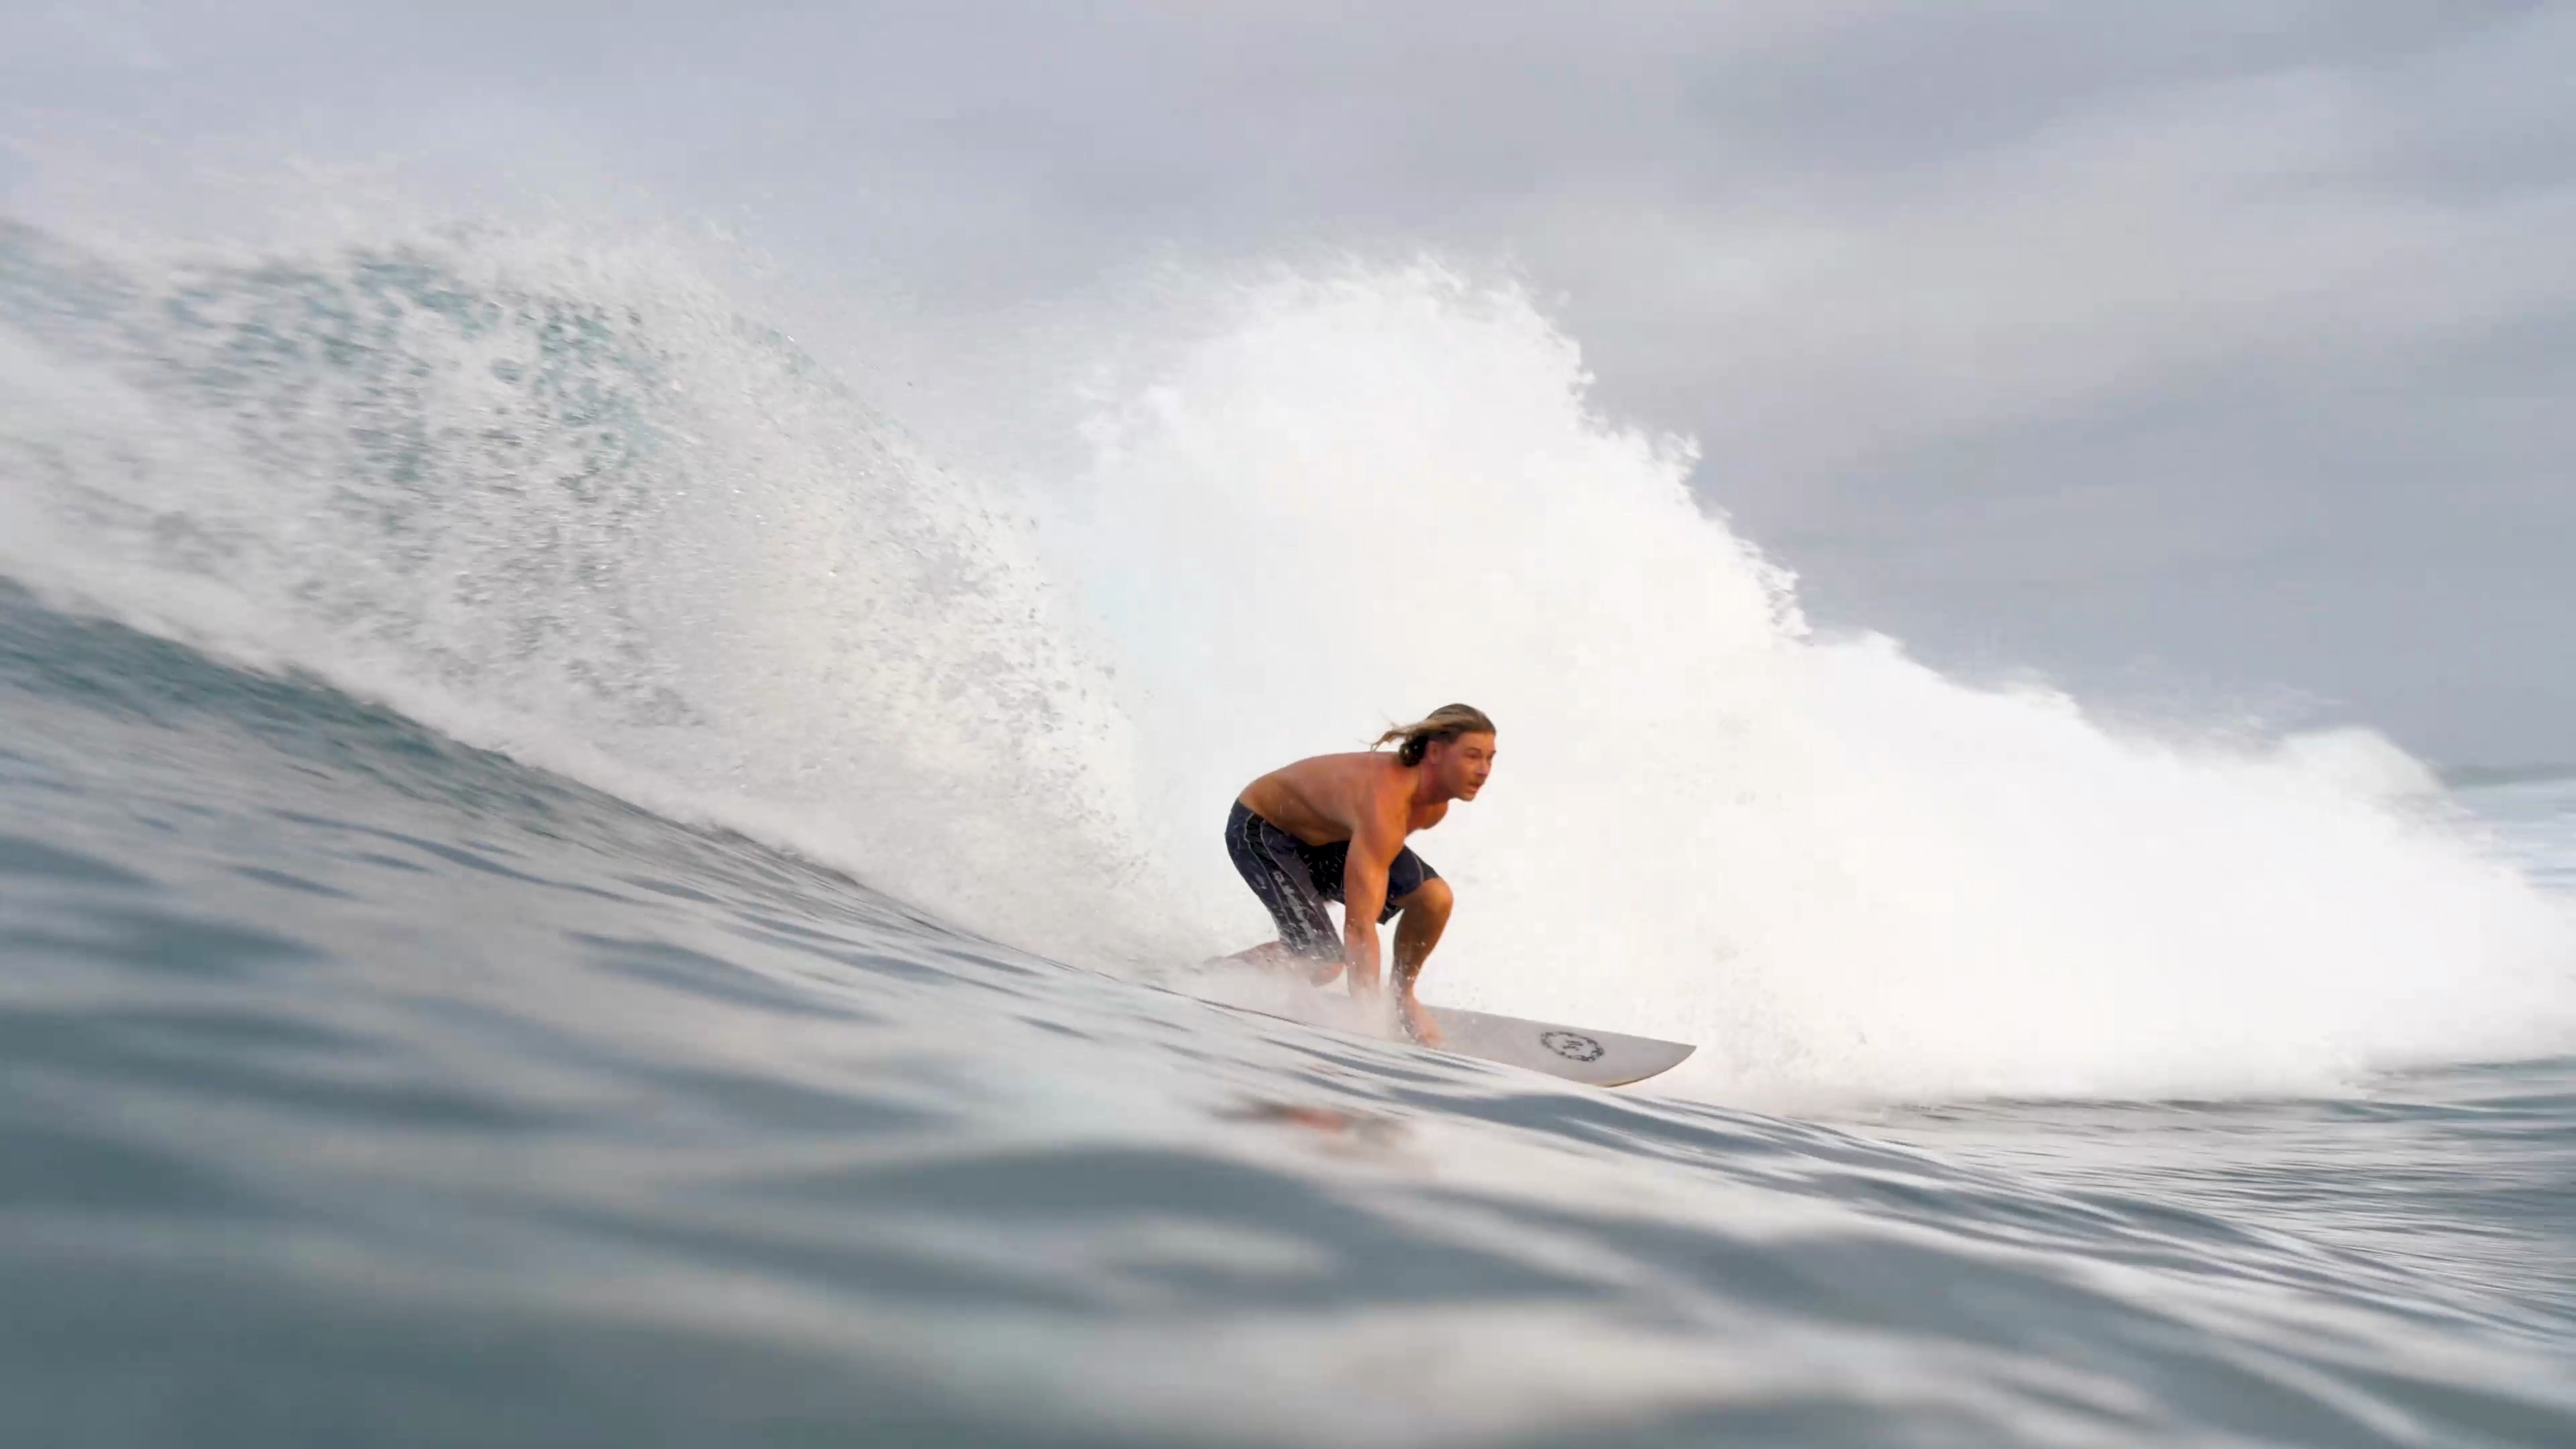
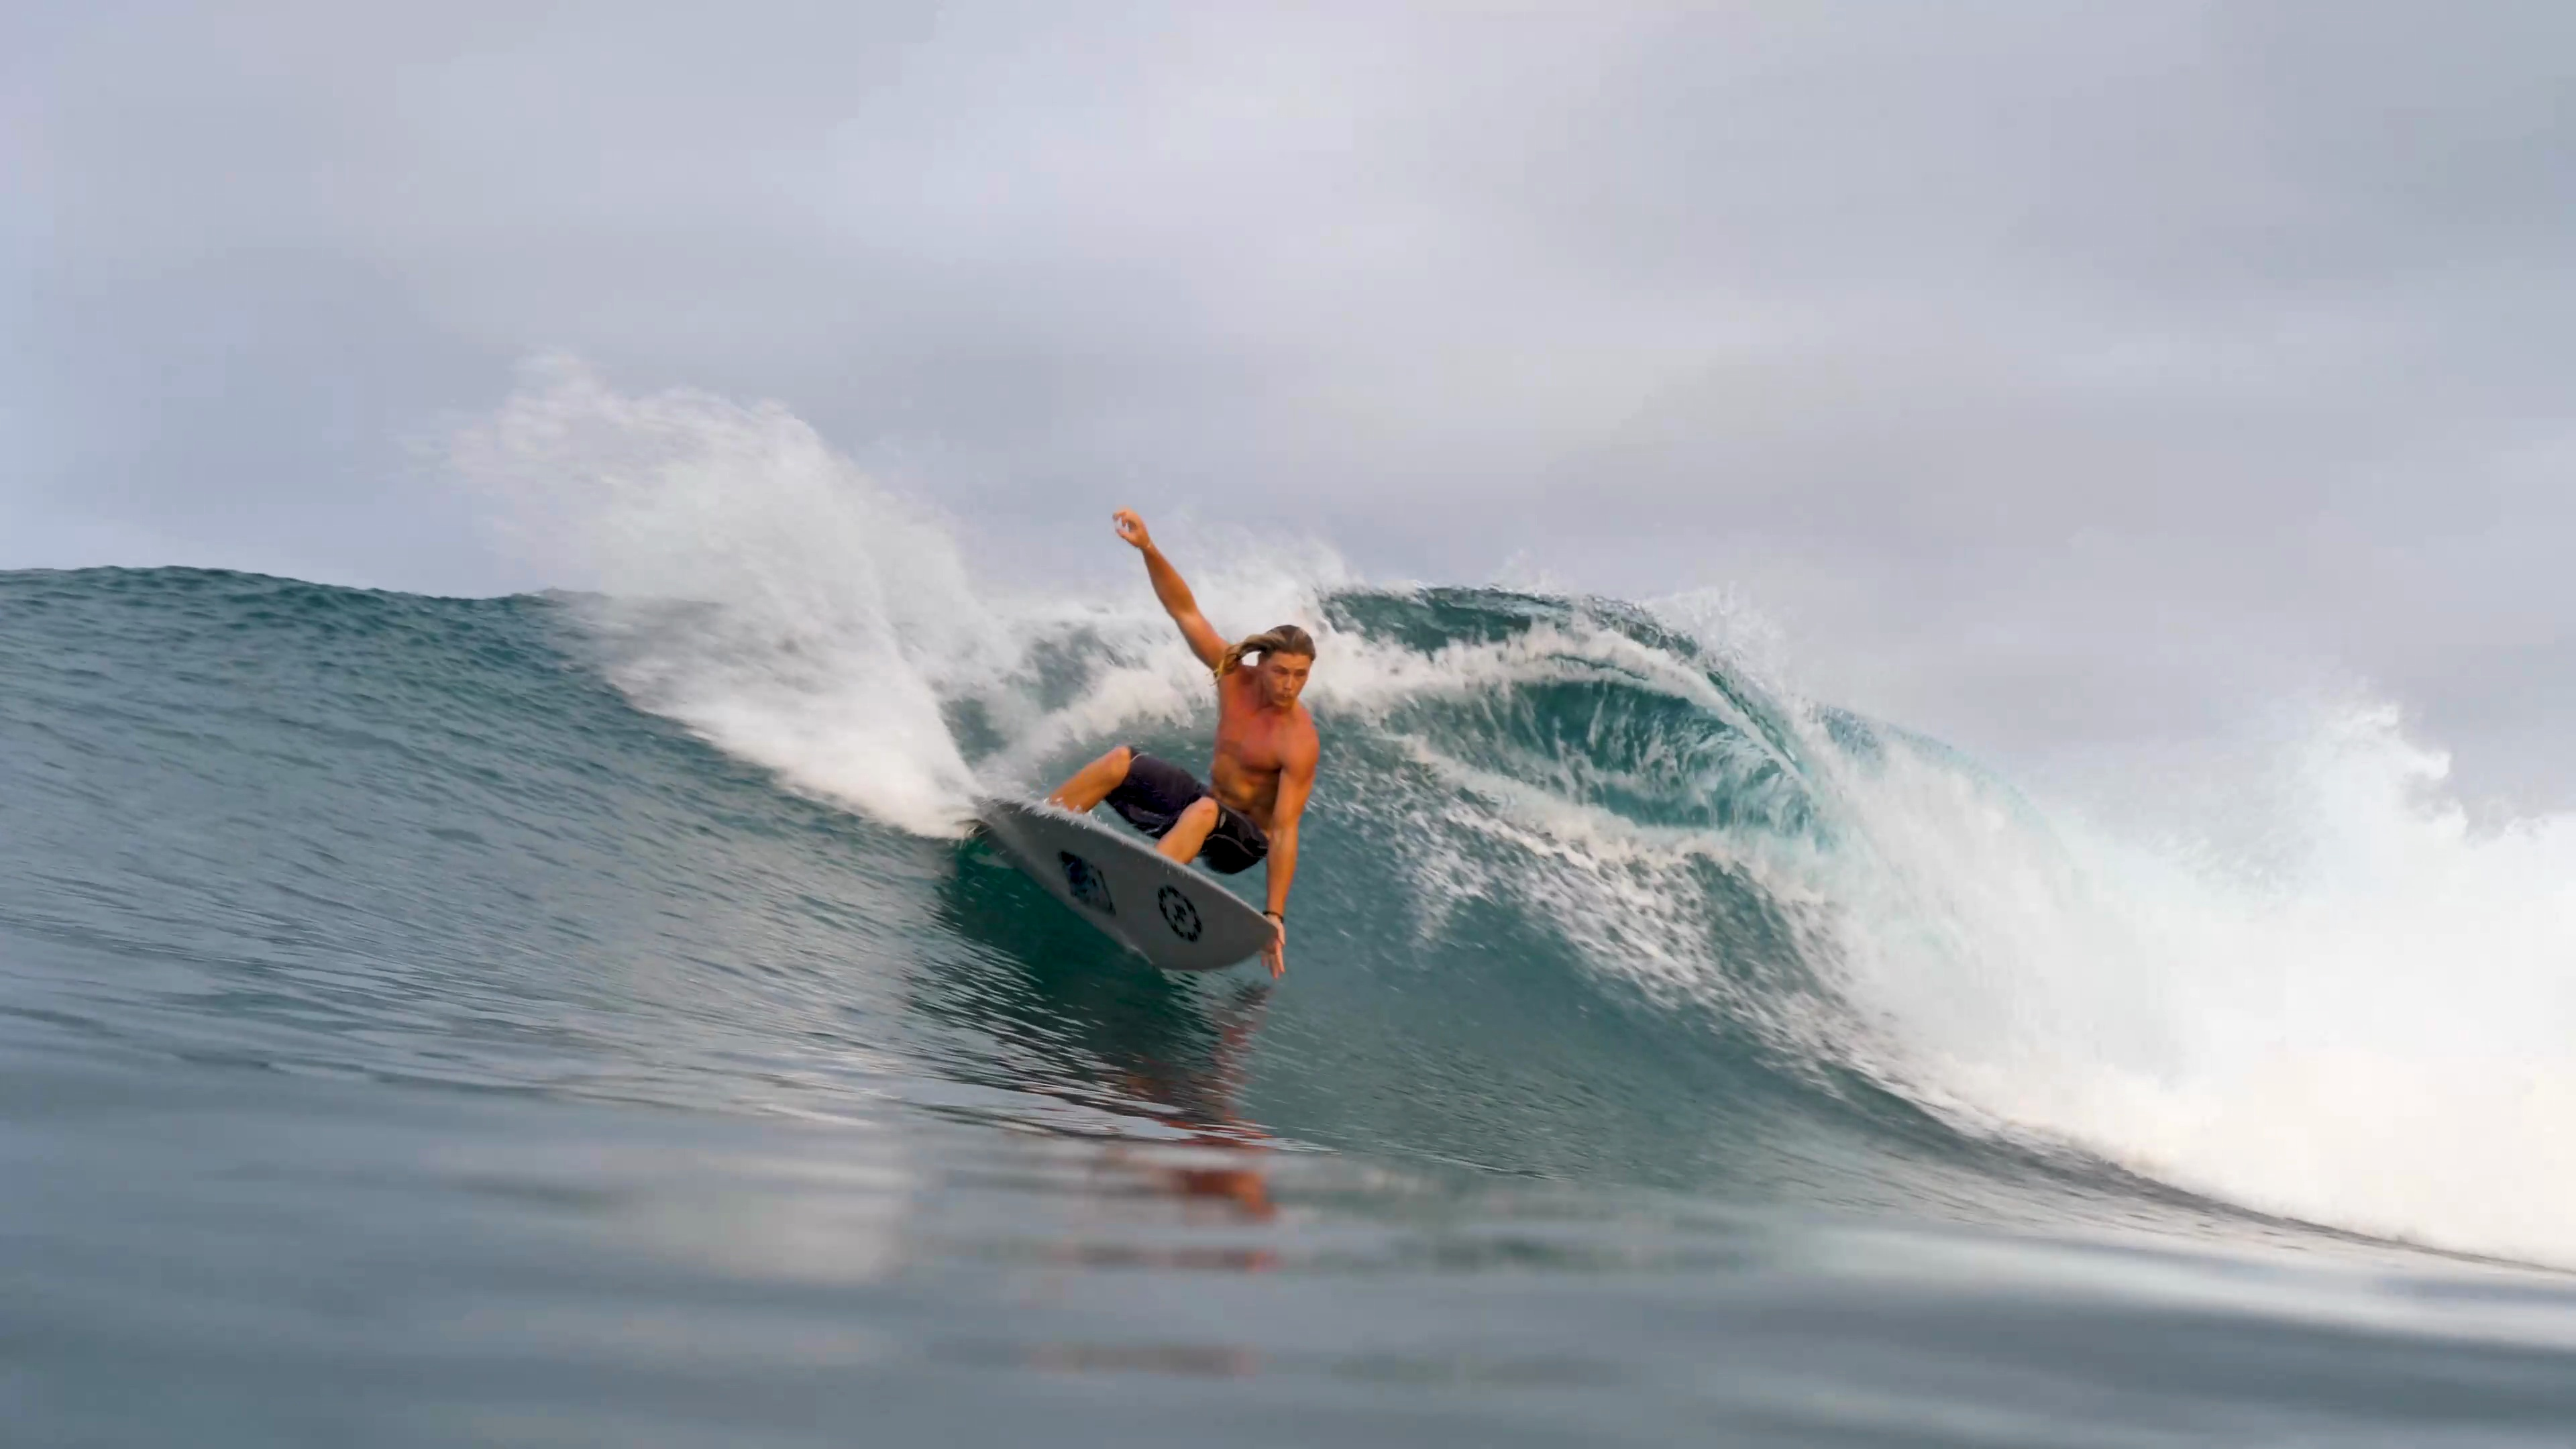
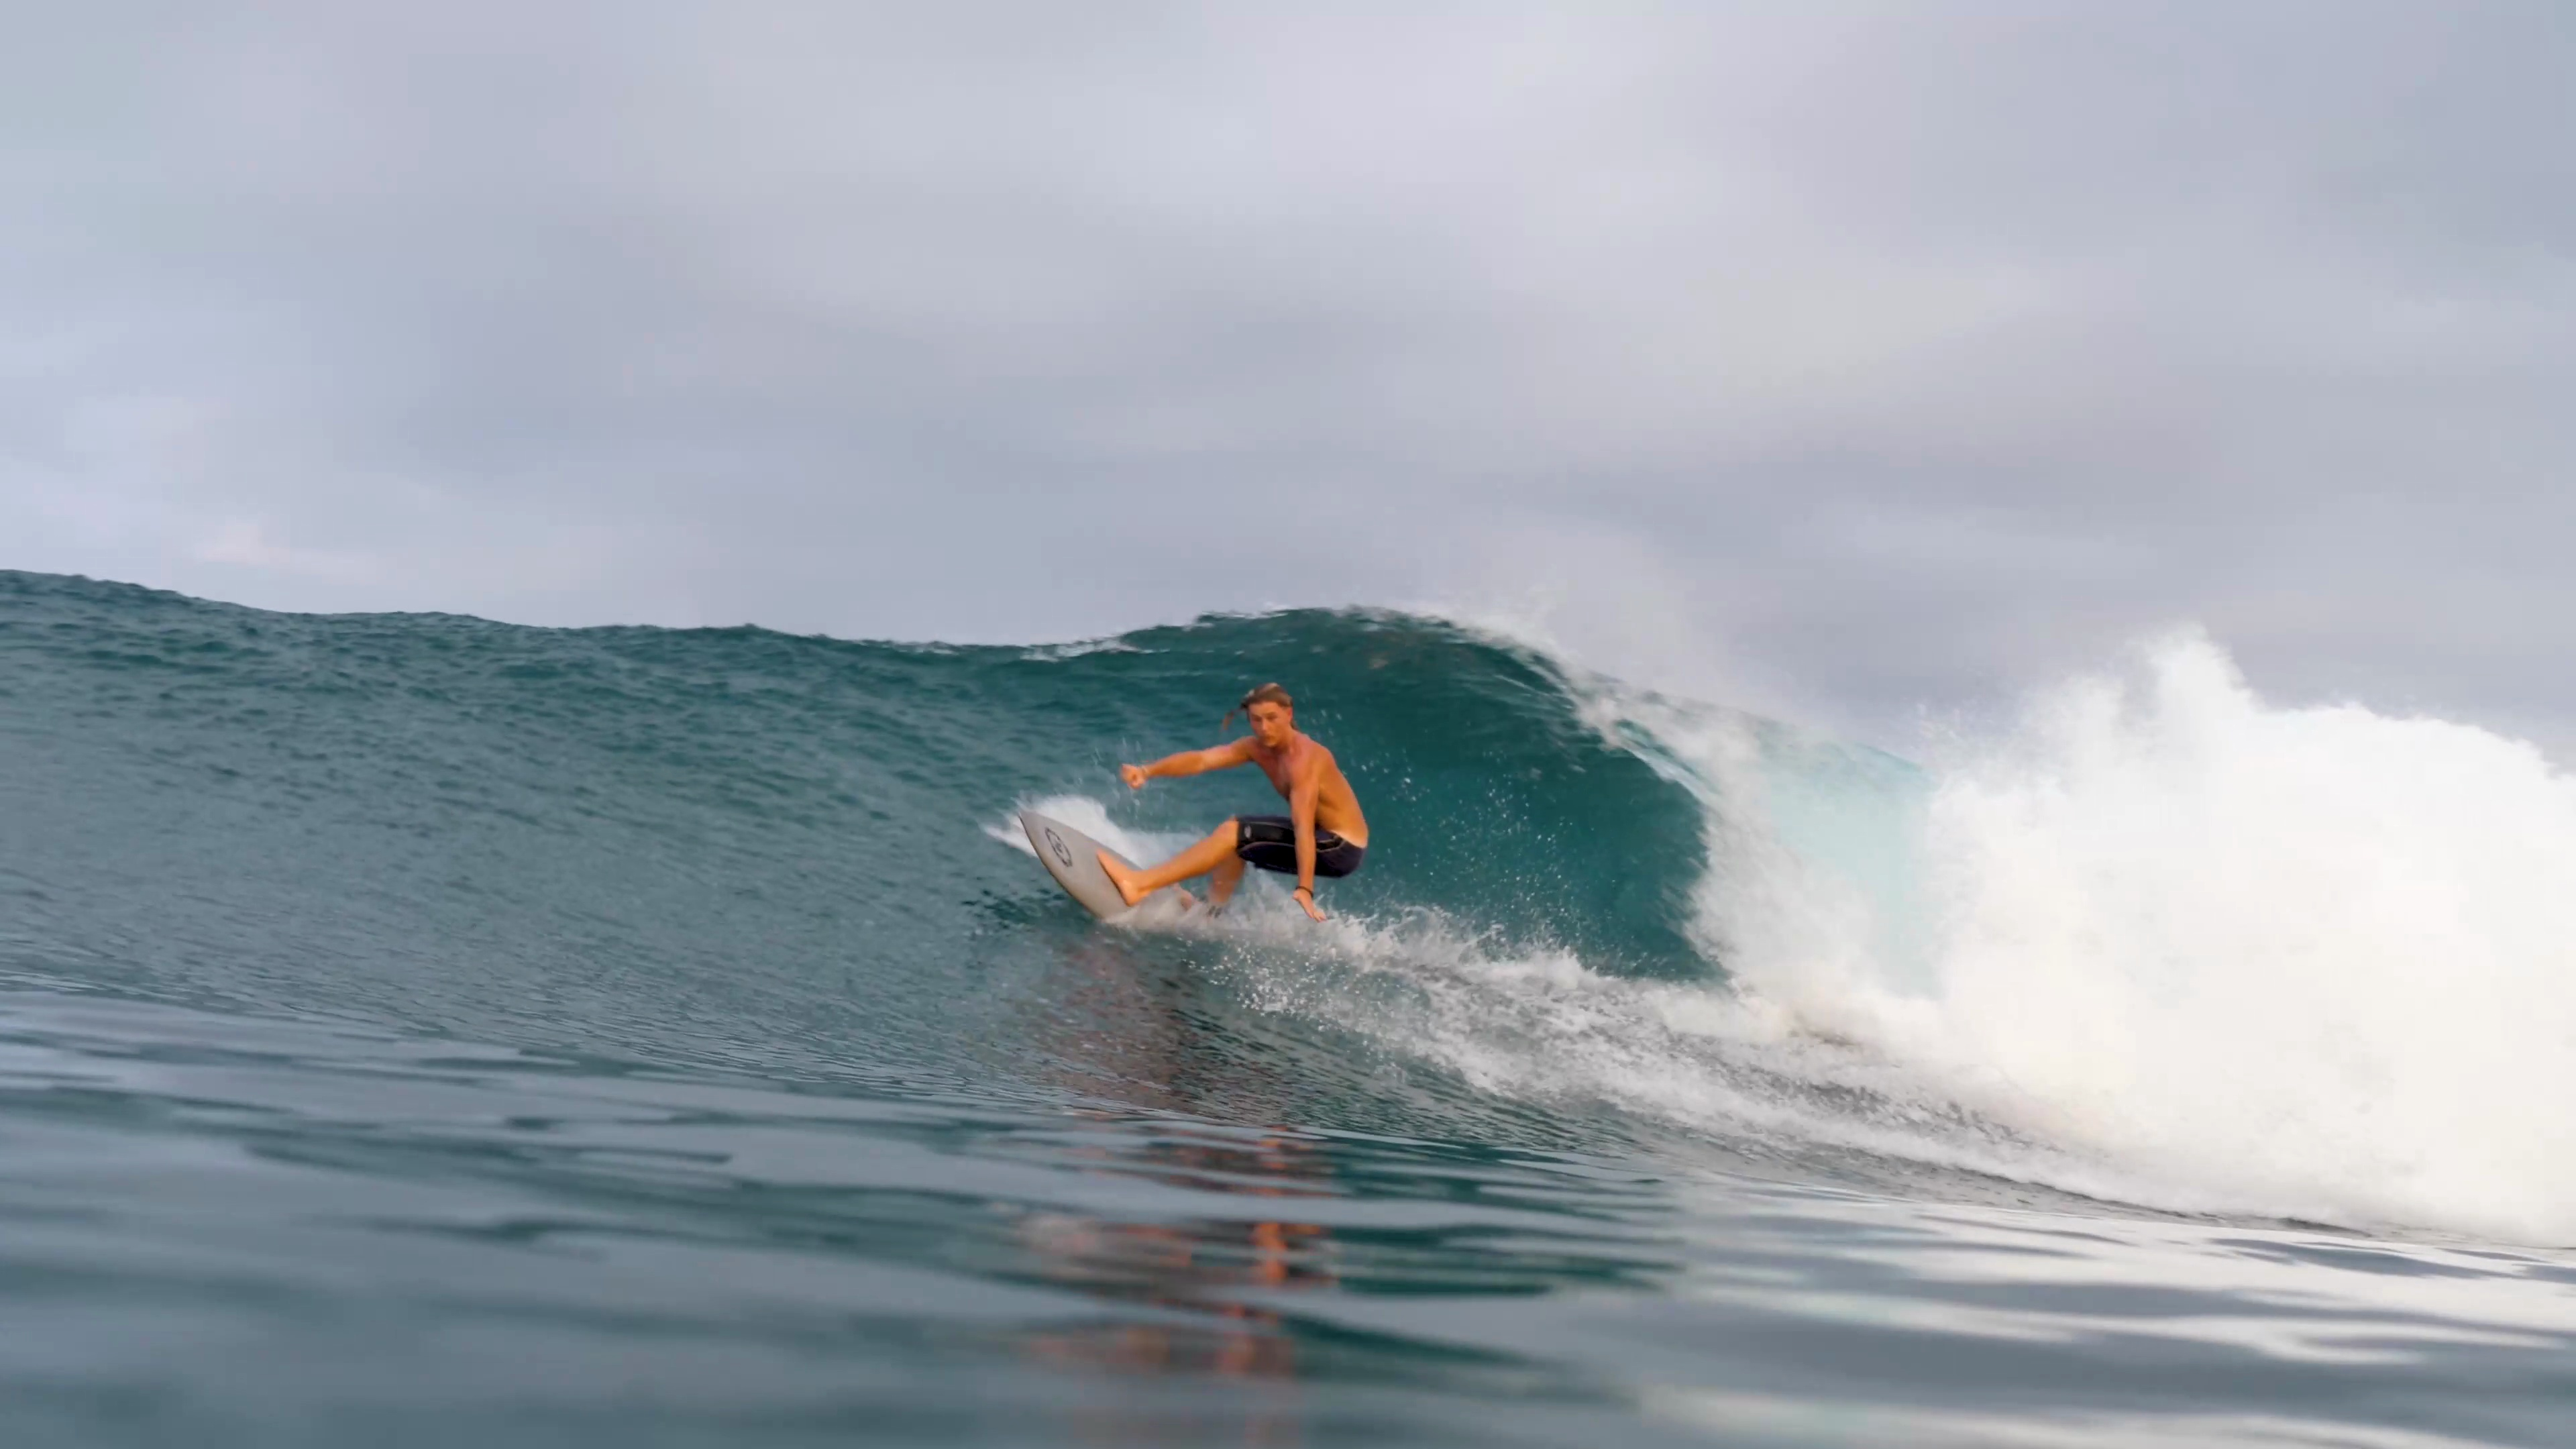
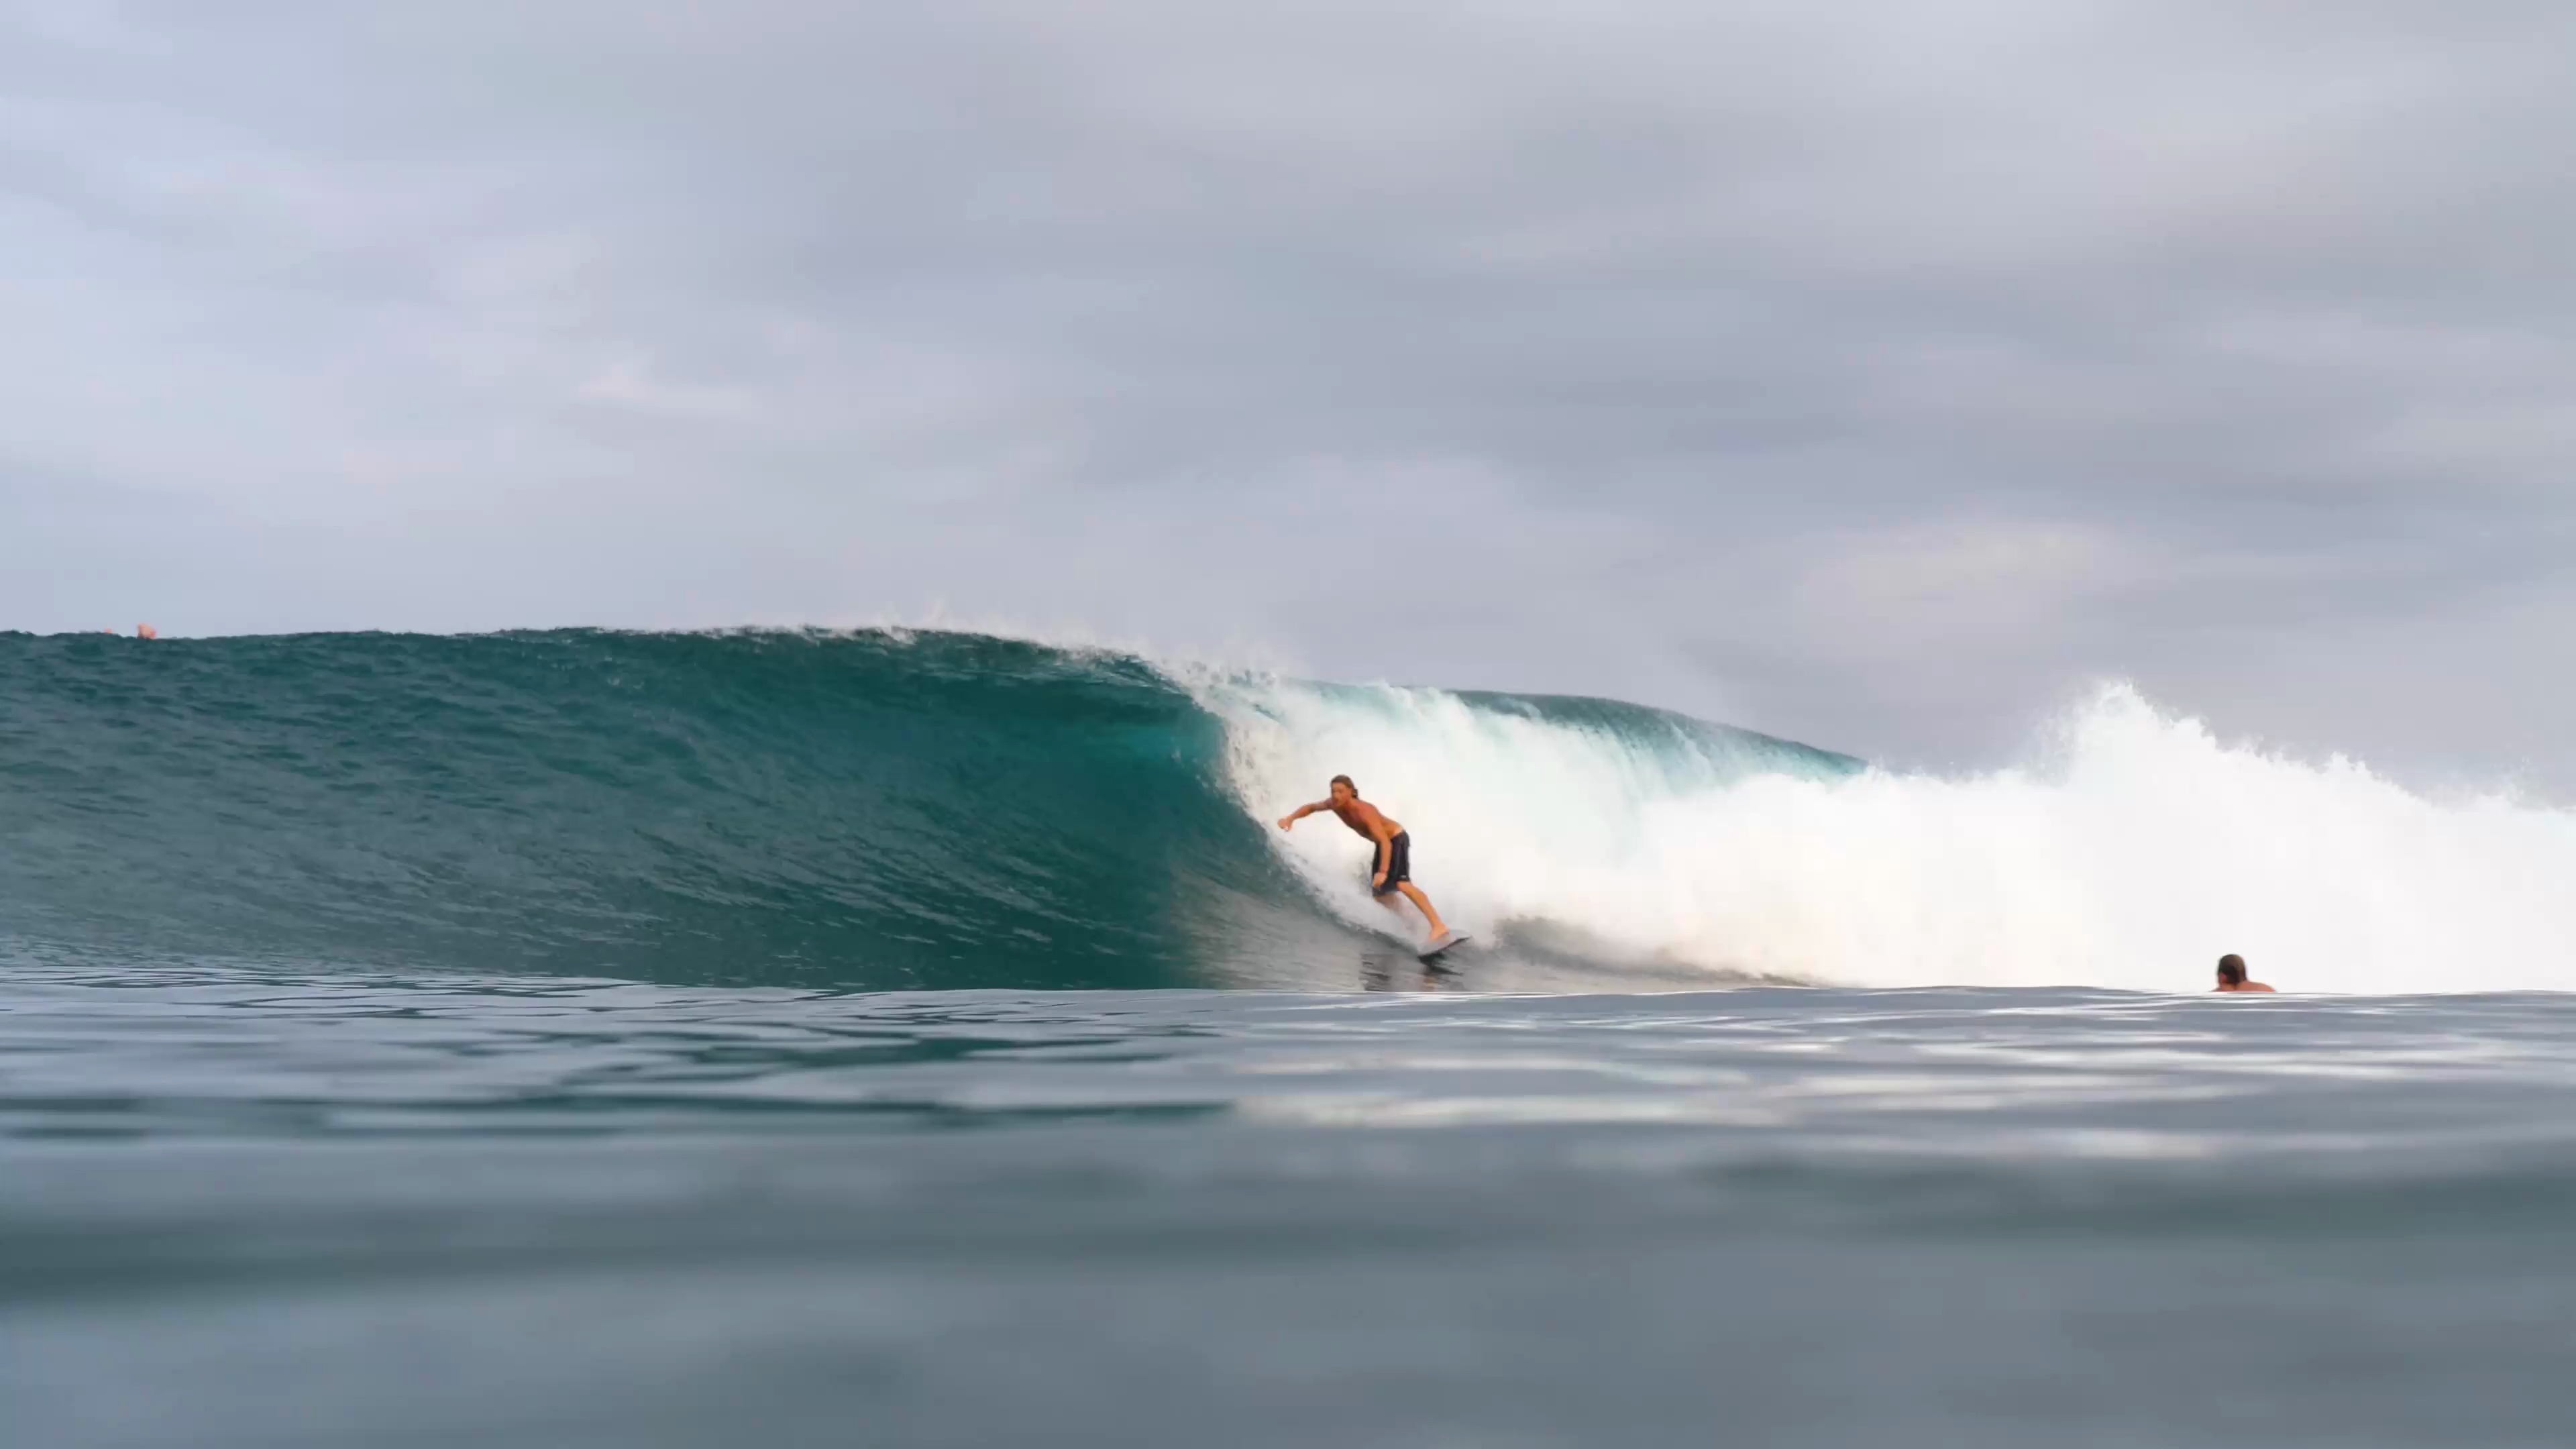
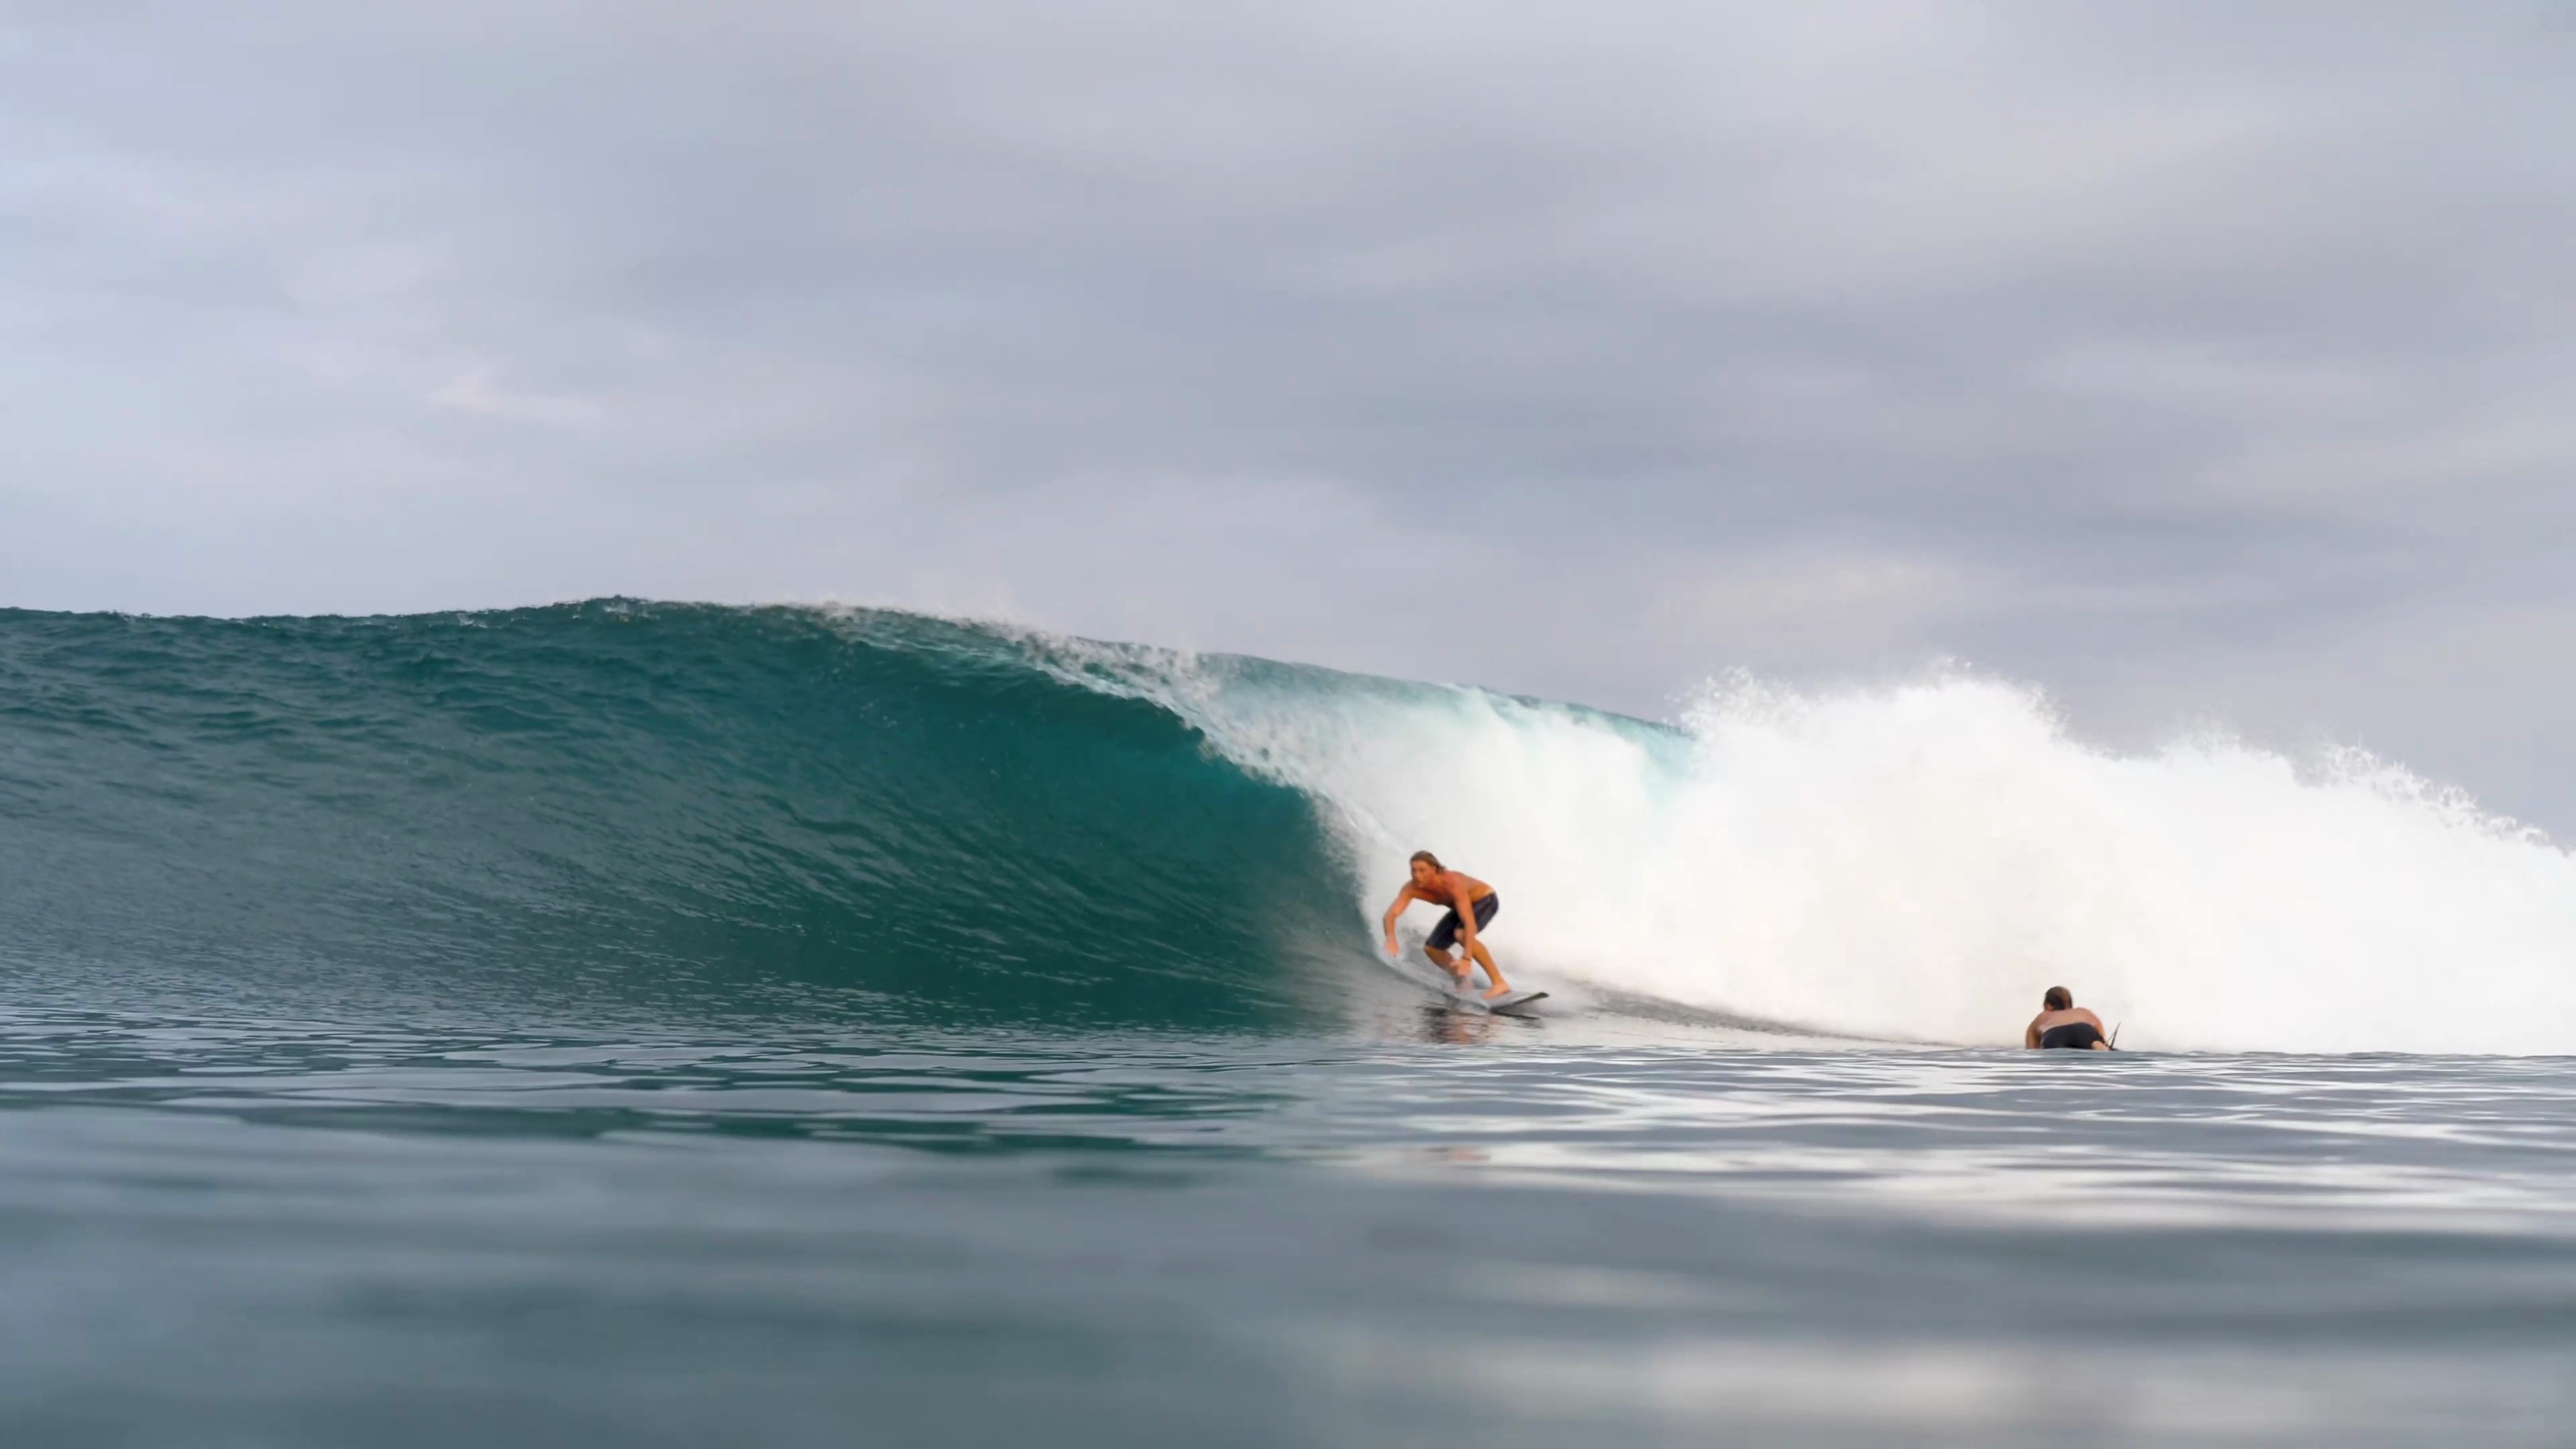
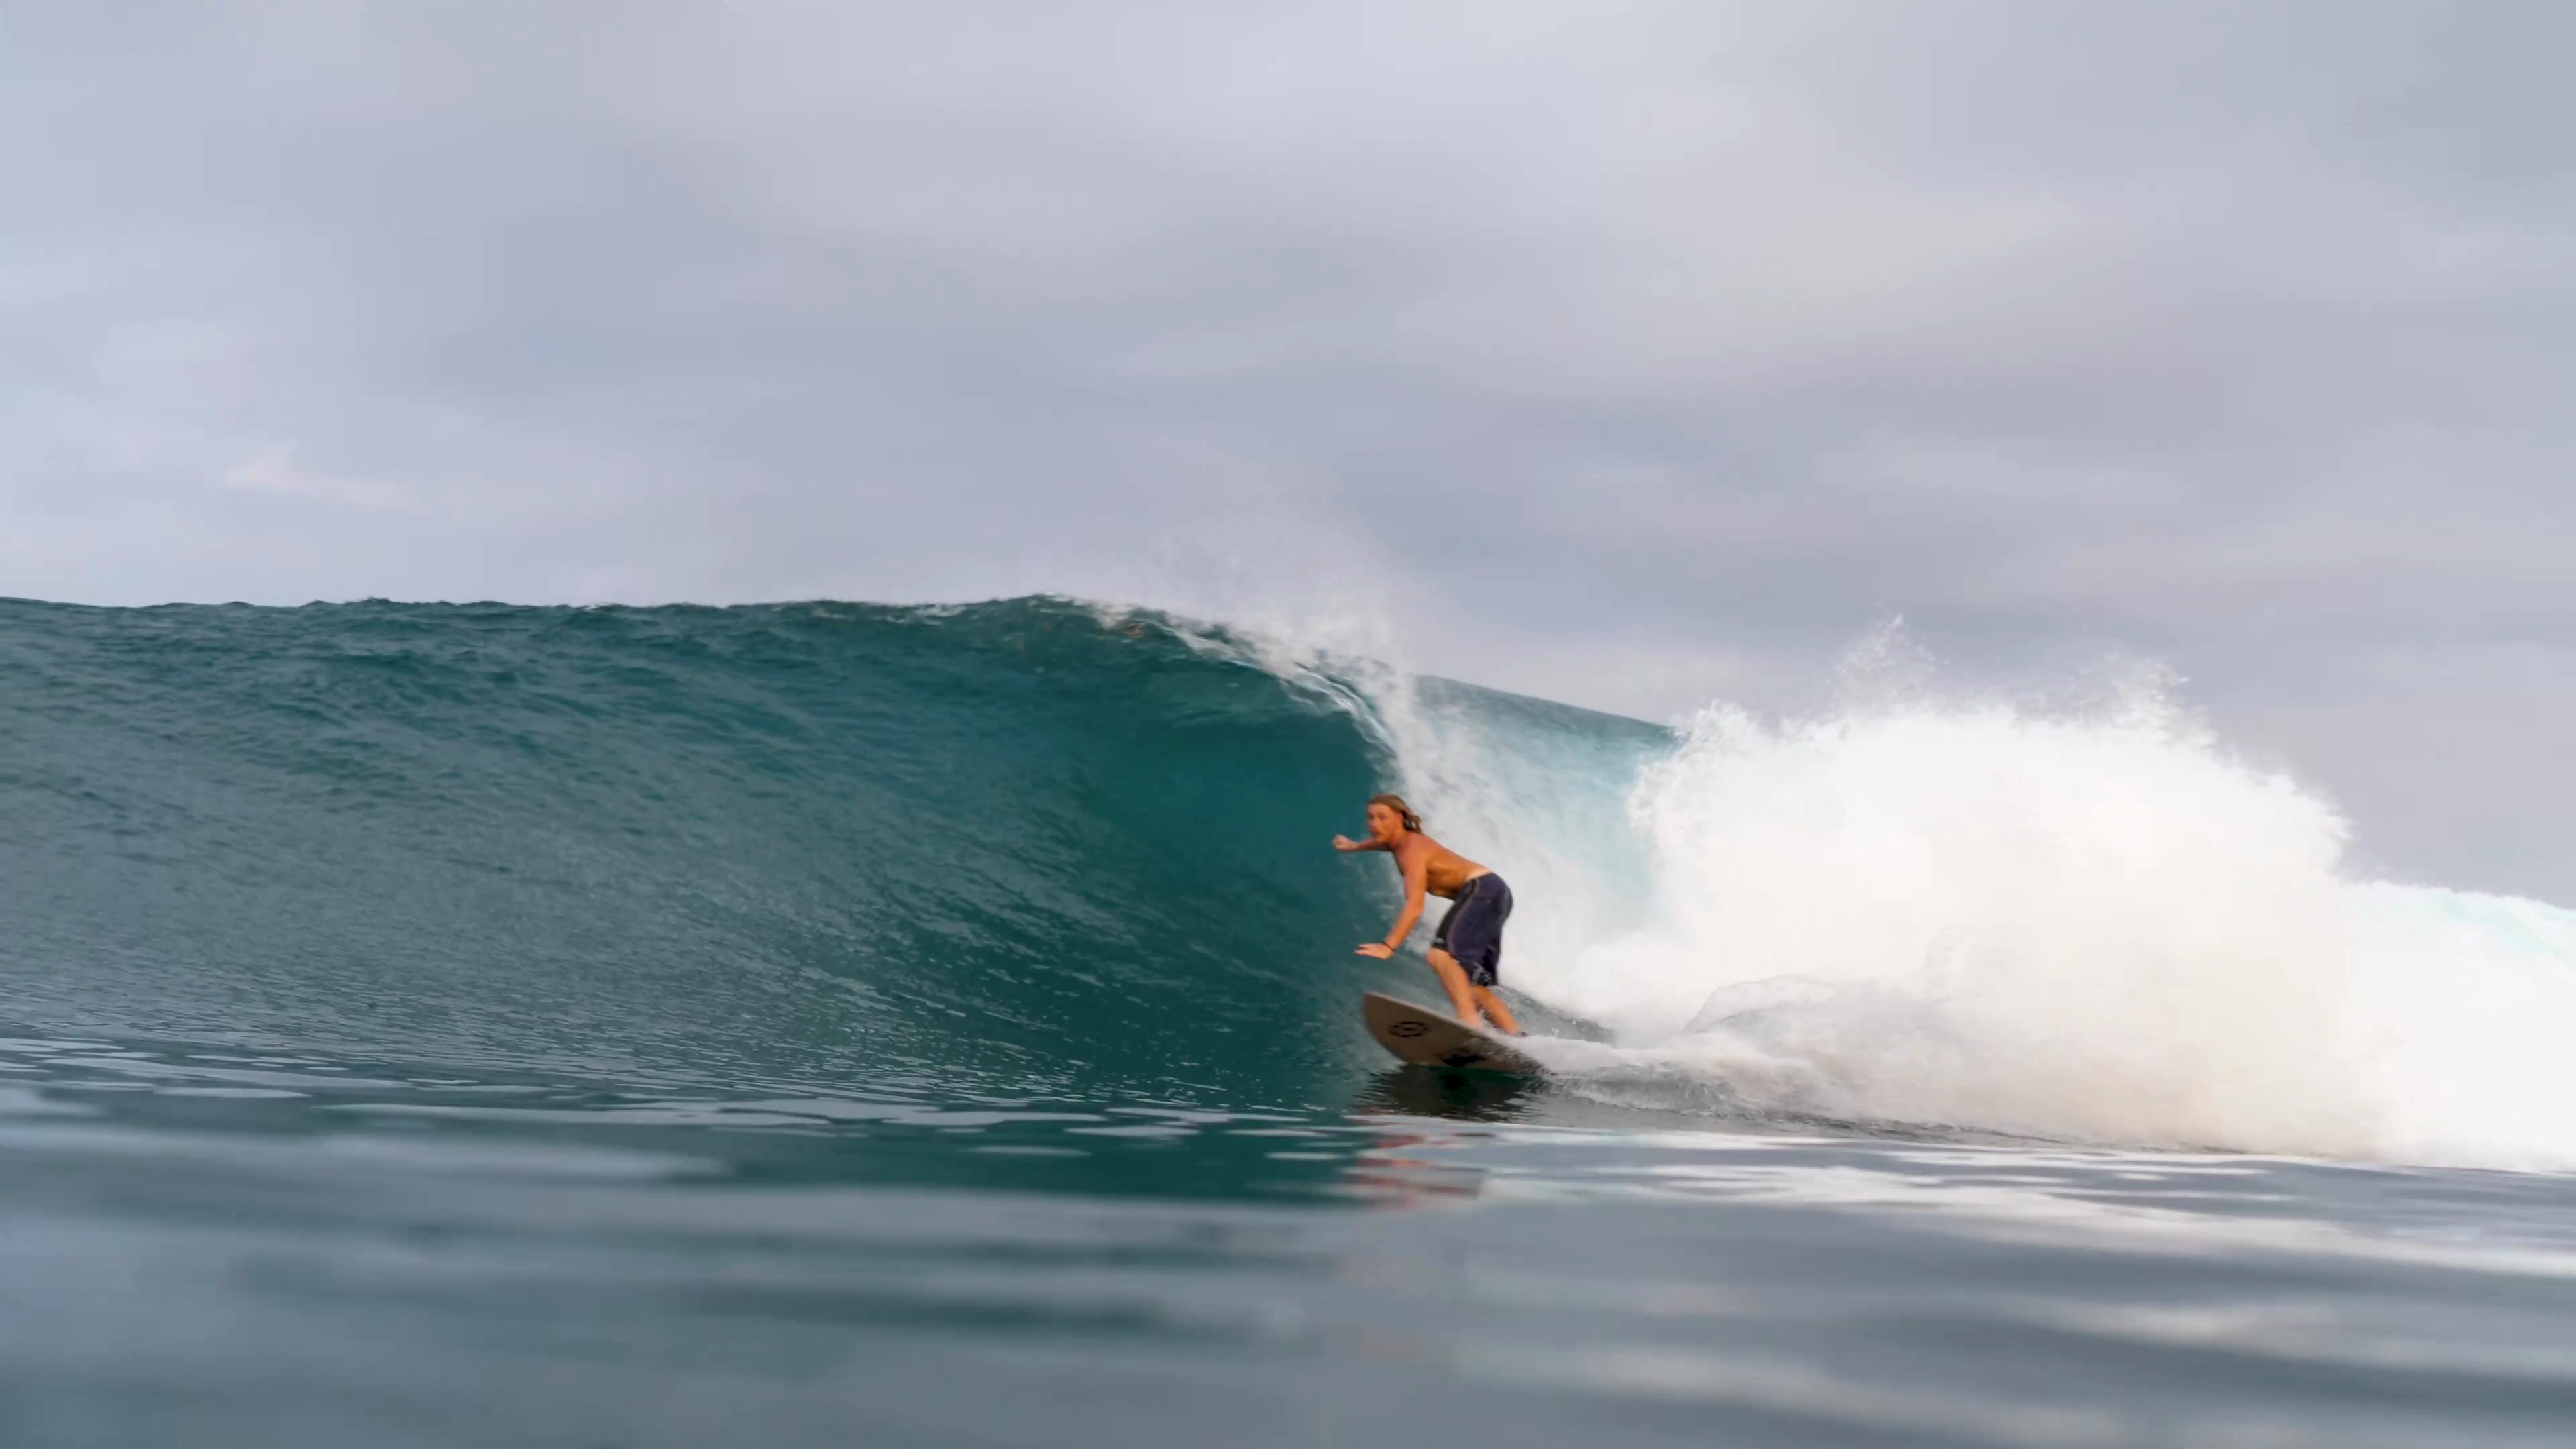
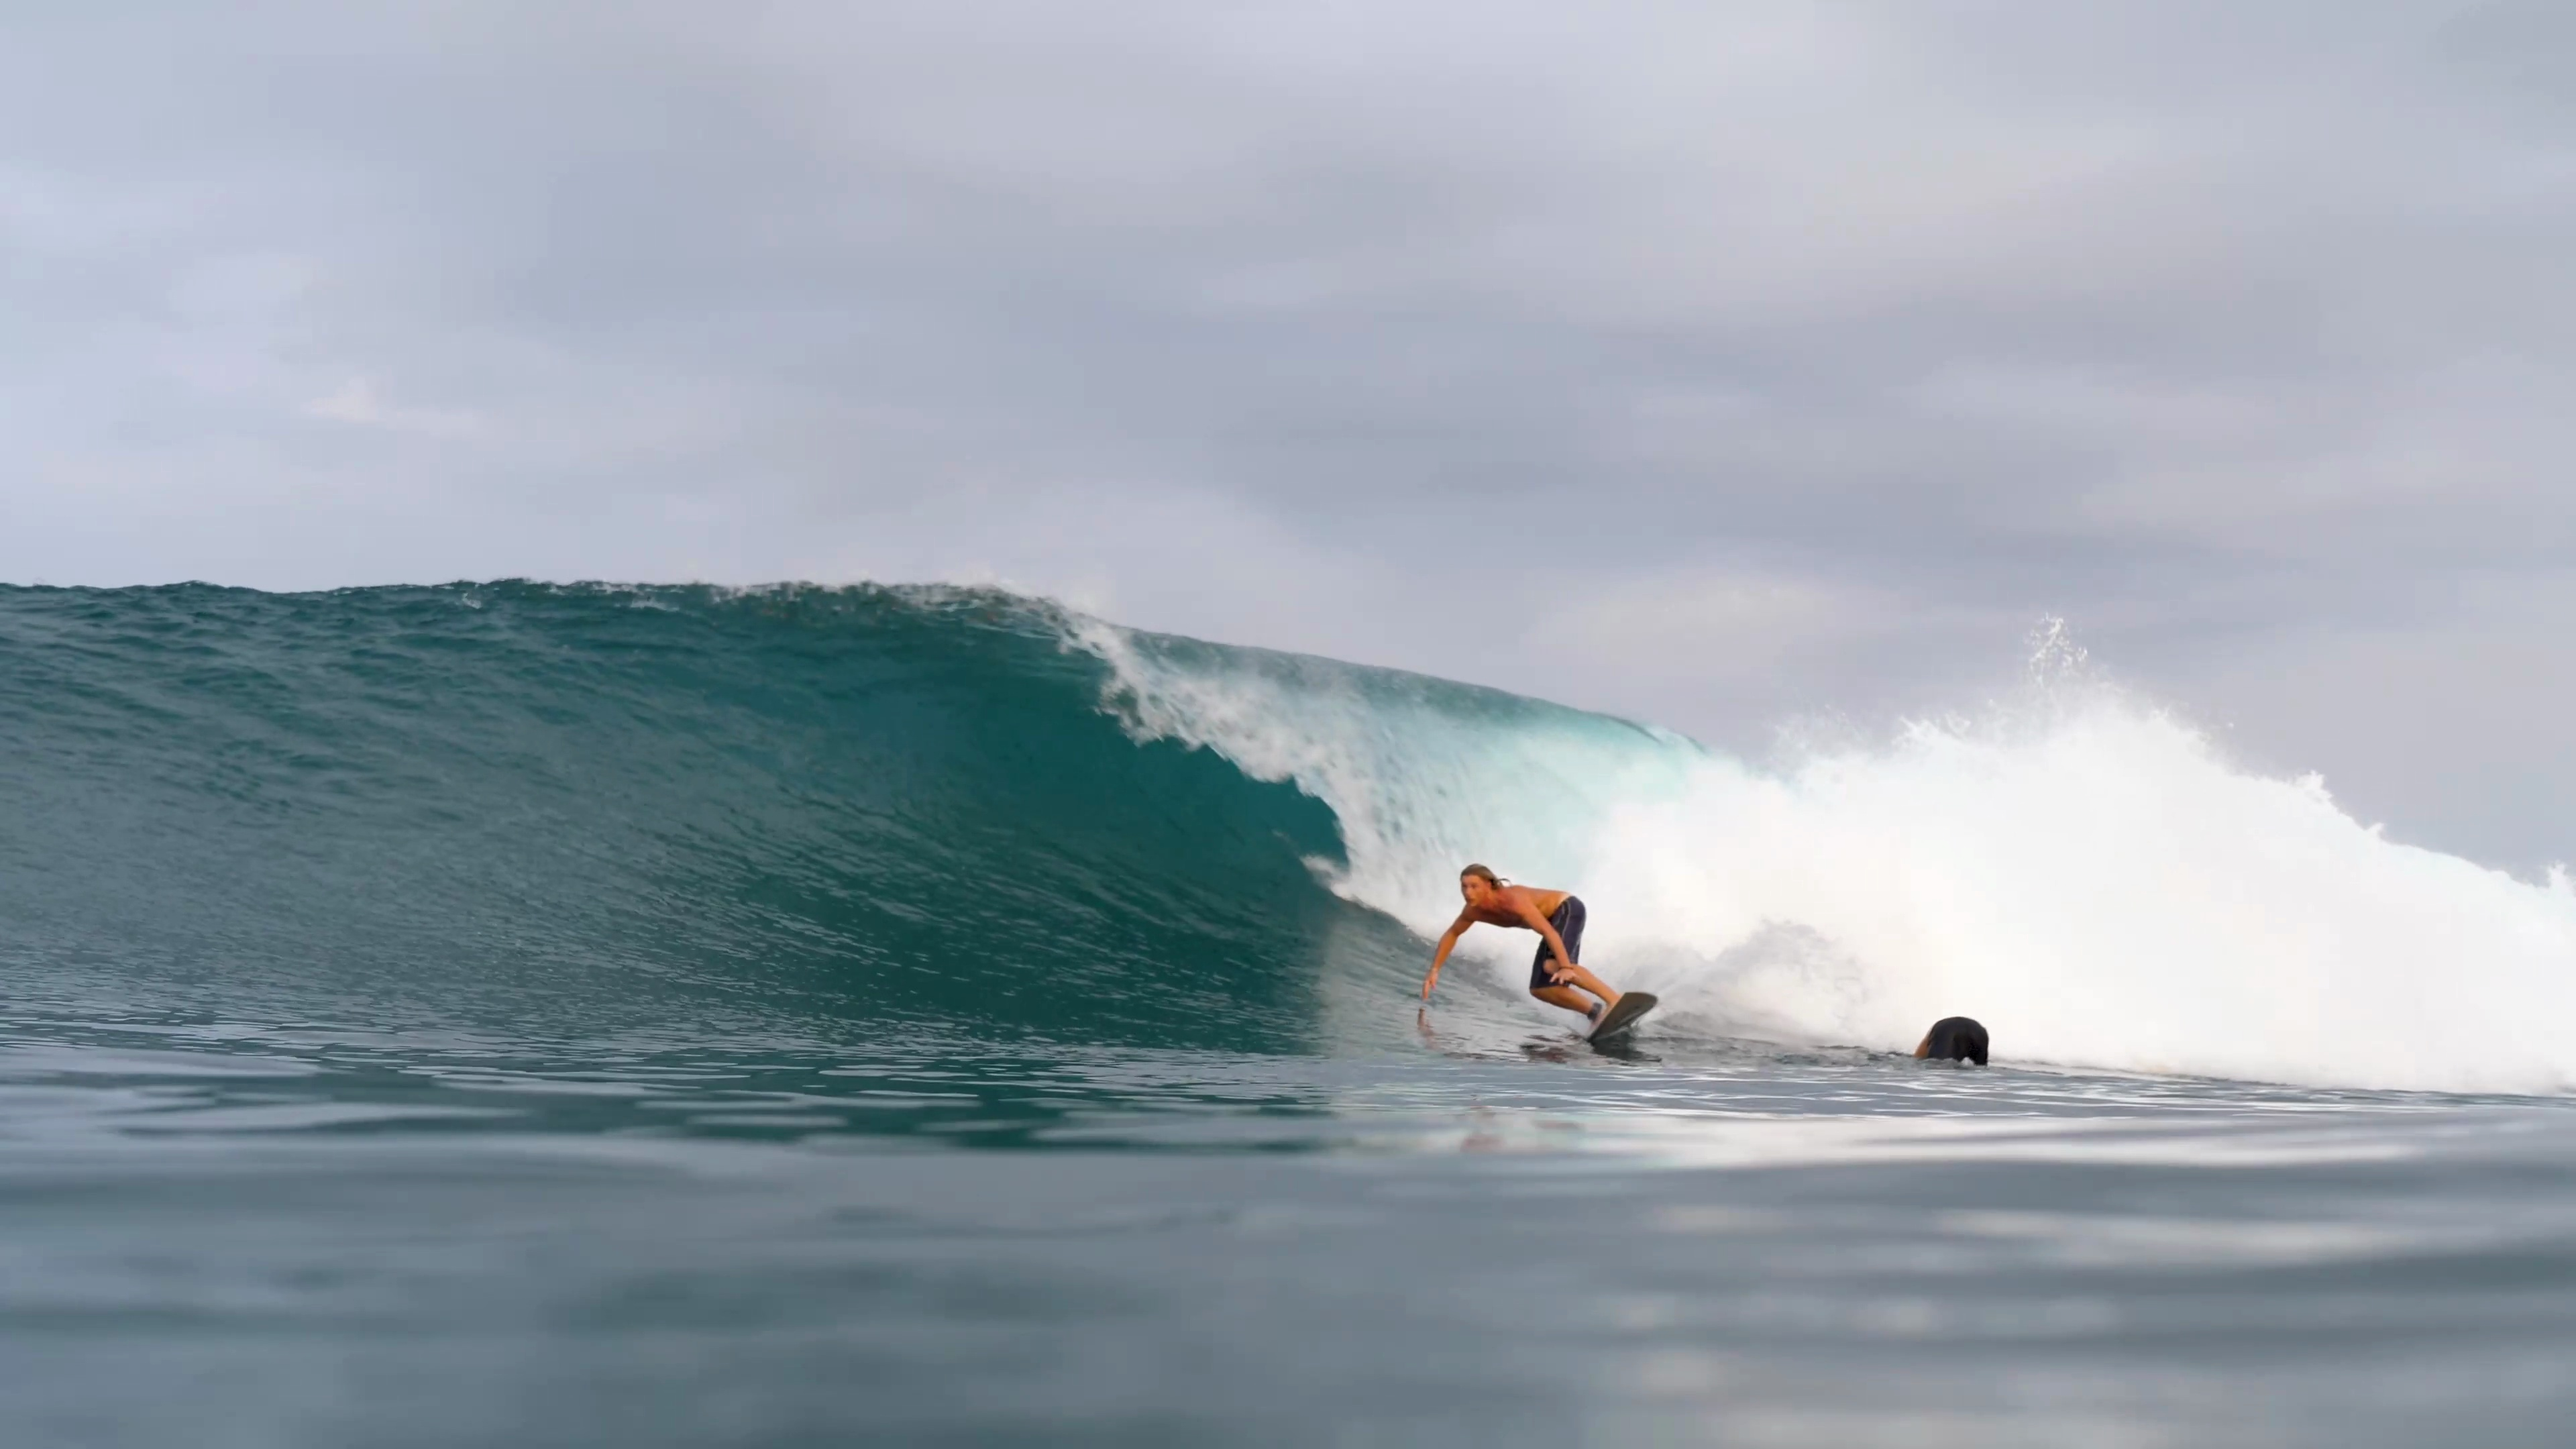
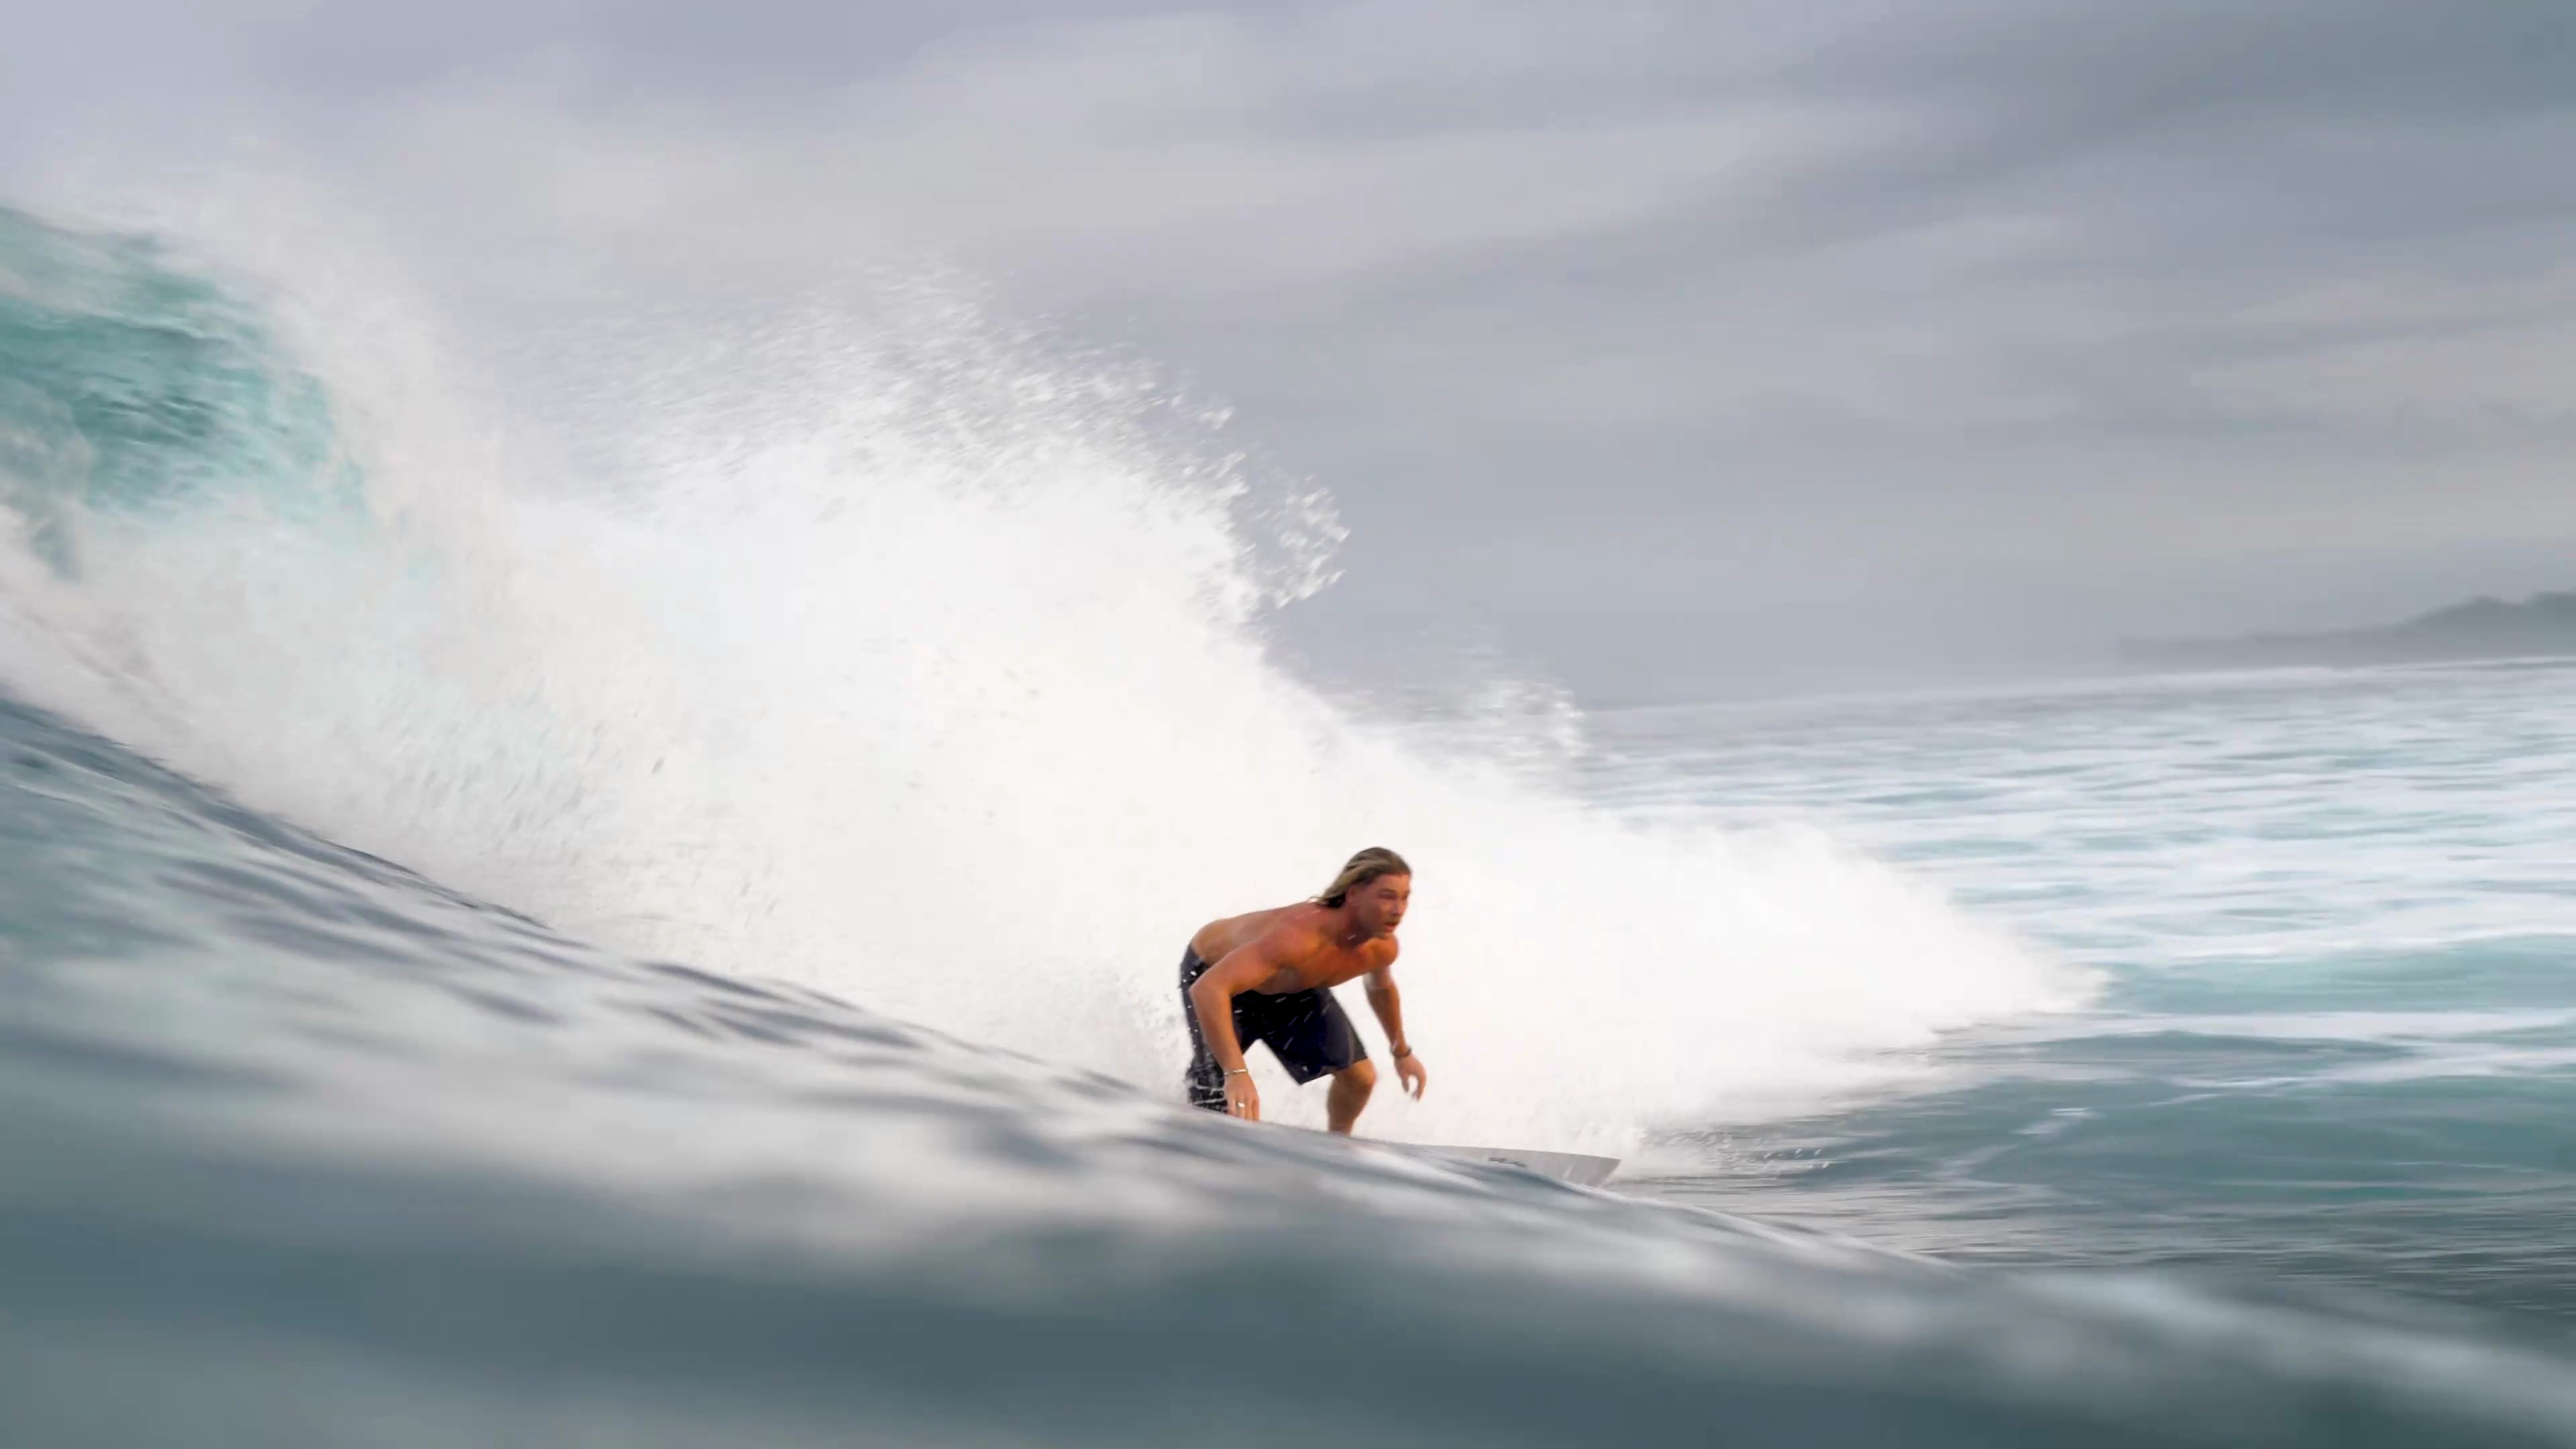

In [8]:
# 1. 결과를 담을 HTML 문자열을 초기화합니다.
# CSS를 사용해 보기 좋은 '카드' 형태로 만듭니다.
html_output = "<div style='display: flex; flex-wrap: wrap; justify-content: center; font-family: sans-serif;'>"

# 2. Base64 이미지 리스트와 예측 결과 리스트를 zip으로 묶어 함께 반복합니다.
# (두 리스트는 순서가 동일합니다)
for b64_img, pred_list, img_path in zip(base64_images, predictions_json, img_paths):
    
    # 3. 예측 결과 파싱 (가장 점수가 높은 첫 번째 예측 사용)
    # transformers의 pipe() 함수는 예측 결과를 반환할 때, 단순히 [surfing, noise] 순서로 반환하는 것이 아니라, 점수(score)가 높은 순서대로 자동 정렬하여 리스트를 반환
    top_pred = pred_list[0]
    label = top_pred['label']
    score = top_pred['score']
    
    # 4. 예측 레이블에 따라 테두리 색상 지정 (noise = red, surfing = green)
    border_color = "red" if label == "noise" else "green"

    # 5. HTML 카드(card)를 만듭니다.
    html_output += f"""
    <div style='border: 3px solid {border_color}; border-radius: 8px; margin: 10px; padding: 10px; text-align: center; box-shadow: 2px 2px 5px rgba(0,0,0,0.1);'>
        
        <img src="data:image/jpeg;base64,{b64_img}" width="224" style='border-radius: 4px;' />
        
        <h3 style='color: {border_color}; margin-bottom: 5px; margin-top: 10px;'>
            Prediction: {label.upper()}
        </h3>
        
        <p style='margin: 0;'>Score: {score:.2%}</p>
        
        <p style='margin-top: 5px; color: #555;'><small>{img_path.name}</small></p>
    </div>
    """

html_output += "</div>"

# 6. Jupyter Notebook 셀에서 HTML 렌더링
display(HTML(html_output))